# Chapter 12: Ensemble methods and decision tree

### 12.1. Decision tree
> ###### 12.1.1. Decision tree classifier
> ###### 12.1.2. Decision tree regressor
> ###### 12.1.3. Optimize the hyperparameters

### 12.2. Random forest
> ###### 12.2.1. Random forest classifier 
> ###### 12.2.2. Random forest regressor
> ###### 12.2.3. Optimize the hyperparameters

### 12.3. Ensemble methods
> ###### 12.3.1. Voting method
> ###### 12.3.2. Bagging method
> ###### 12.3.3. Stacking method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *

In [2]:
# Import the data
df = yf.download("GOOG", end="2021-01-01")[["Adj Close"]].pct_change(1) #GOOG
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()



# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]
y_train_reg = df[["returns"]].iloc[:split]
y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]
y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)



# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 12.1.1. Decision tree classifier

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.056 	 Alpha: 12.44 %	     Sharpe: 0.931 	 Sortino: 1.227
  -----------------------------------------------------------------------------
    VaR: 41.48 %	 cVaR: 51.86 % 	     VaR/cVaR: 1.25 	 drawdown: 30.79 %
  -----------------------------------------------------------------------------


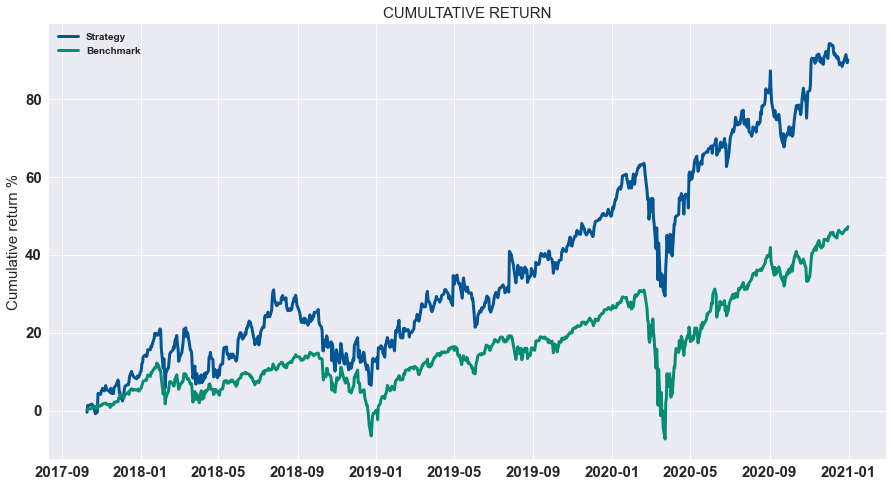

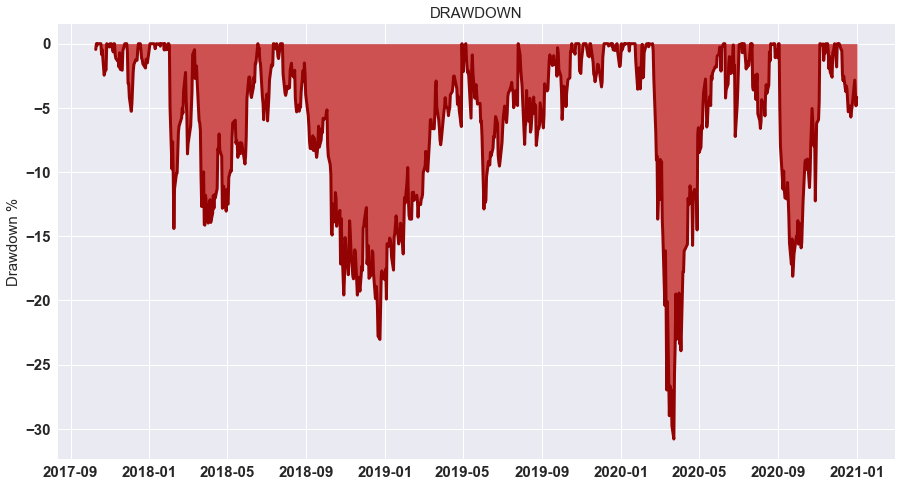

In [3]:
# Import the class
from sklearn.tree import DecisionTreeClassifier

# Initialize the class
dtc = DecisionTreeClassifier(max_depth=6)

# Fit the model
dtc.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = dtc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.046 	 Alpha: -25.96 %	     Sharpe: -0.889 	 Sortino: -1.131
  -----------------------------------------------------------------------------
    VaR: 96.2 %	 cVaR: 106.56 % 	     VaR/cVaR: 1.108 	 drawdown: 64.52 %
  -----------------------------------------------------------------------------


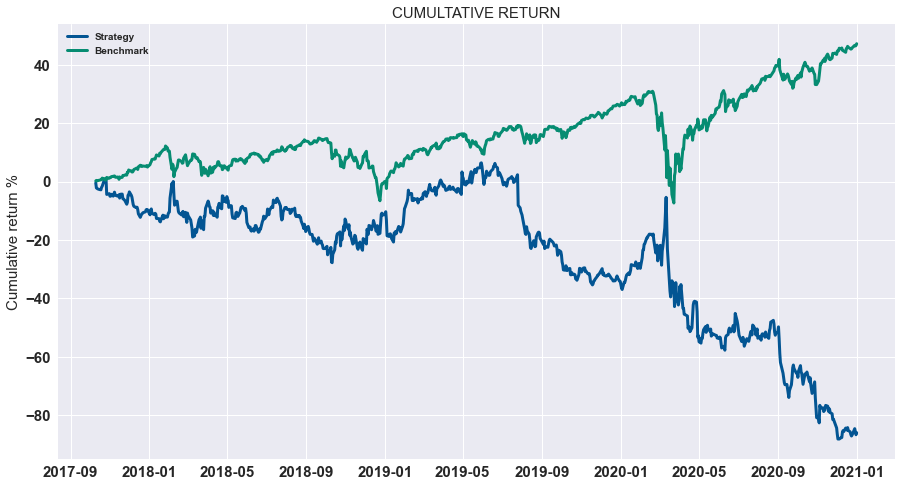

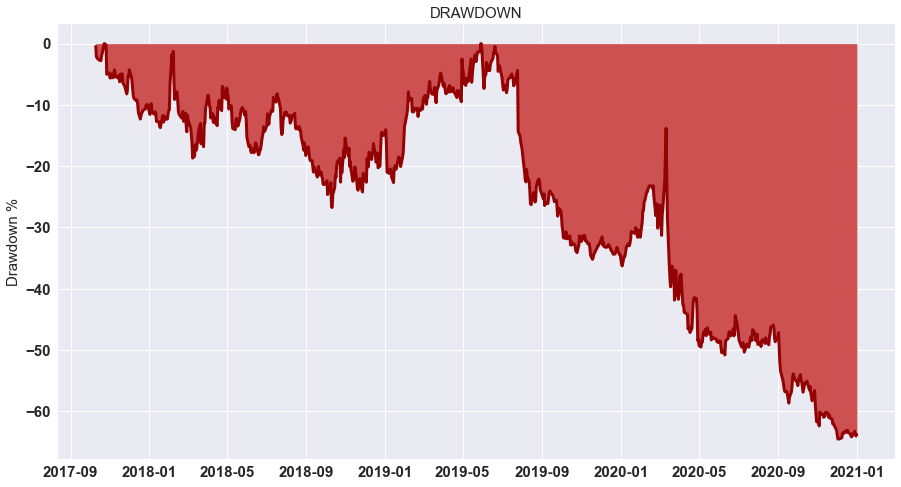

In [4]:
# Initialize the class
trc_no_maxdepth = DecisionTreeClassifier()

# Fit the model
trc_no_maxdepth.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = trc_no_maxdepth.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.1.2. Decision tree regressor

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.349 	 Alpha: 22.55 %	     Sharpe: 0.923 	 Sortino: 1.27
  -----------------------------------------------------------------------------
    VaR: 42.29 %	 cVaR: 52.52 % 	     VaR/cVaR: 1.242 	 drawdown: 25.35 %
  -----------------------------------------------------------------------------


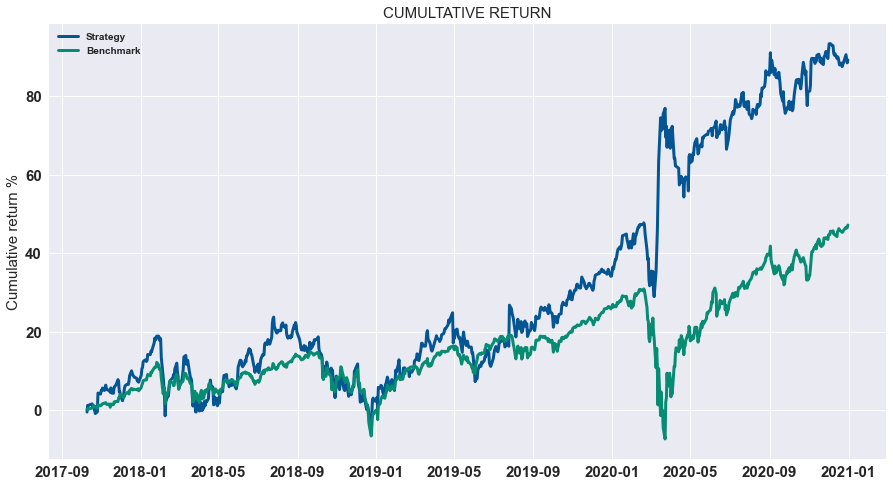

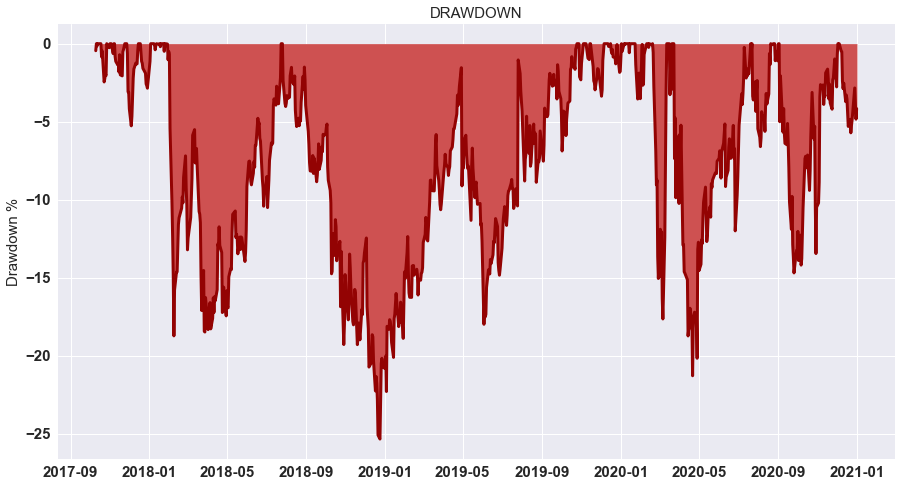

In [5]:
# Import the class
from sklearn.tree import DecisionTreeRegressor

# Initialize the class
dtr = DecisionTreeRegressor(max_depth=6)

# Fit the model
dtr.fit(X_train, y_train_reg)

# Create predictions for the whole dataset
df["prediction"] = dtr.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.1.3. Optimize the hyperparameters

In [6]:
# Import the class
from sklearn.model_selection import GridSearchCV

# Create the model
dtr = DecisionTreeRegressor()

# Choose a list of parameters
param = {"max_depth": [3,6,15]}

# Create the GridSearch
model = GridSearchCV(dtr, param_grid=param, cv=3,)

# Train the model
model.fit(X_train.values, y_train_reg.values)

# Print best model
model.best_estimator_

DecisionTreeRegressor(max_depth=3)

In [7]:
# Import the function
from sklearn.metrics import make_scorer

# RETURNS
# Create returns criterion
def returns(y, y_pred):
    return np.sum(np.sign(y_pred) * y)

# Transform criterion into a metric
returns_metric  = make_scorer(returns, greater_is_better=True)

# SHARPE
# Create sharpe criterion
def sharpe(y, y_pred):
    r = np.sign(y_pred) * y
    return np.mean(r) / np.std(r)

# Transform criterion into a metric
sharpe_metric  = make_scorer(sharpe, greater_is_better=True)


In [8]:
model = GridSearchCV(dtr, param_grid=param, scoring=sharpe_metric, cv=3)

model.fit(X_train.values, y_train_reg.values)

model.best_estimator_

DecisionTreeRegressor(max_depth=3)

### 12.2.1. Random forest classifier

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.069 	 Alpha: -5.47 %	     Sharpe: -0.149 	 Sortino: -0.189
  -----------------------------------------------------------------------------
    VaR: 74.19 %	 cVaR: 84.47 % 	     VaR/cVaR: 1.138 	 drawdown: 57.39 %
  -----------------------------------------------------------------------------


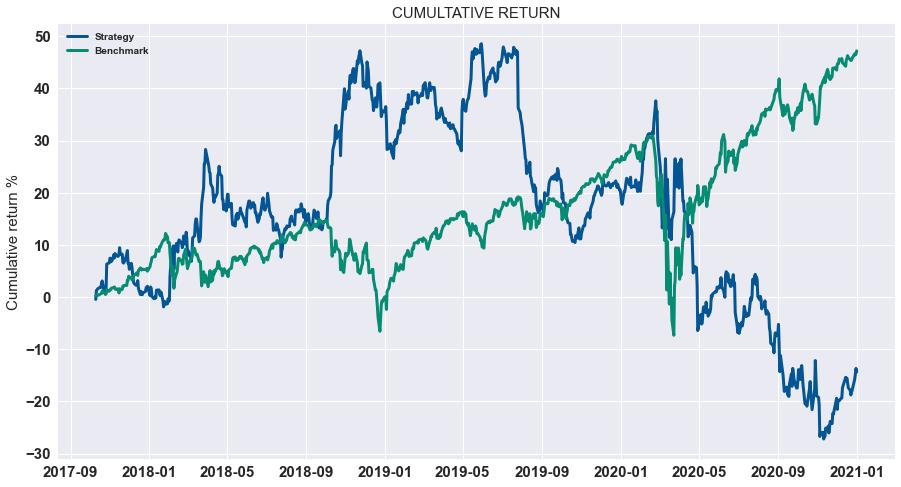

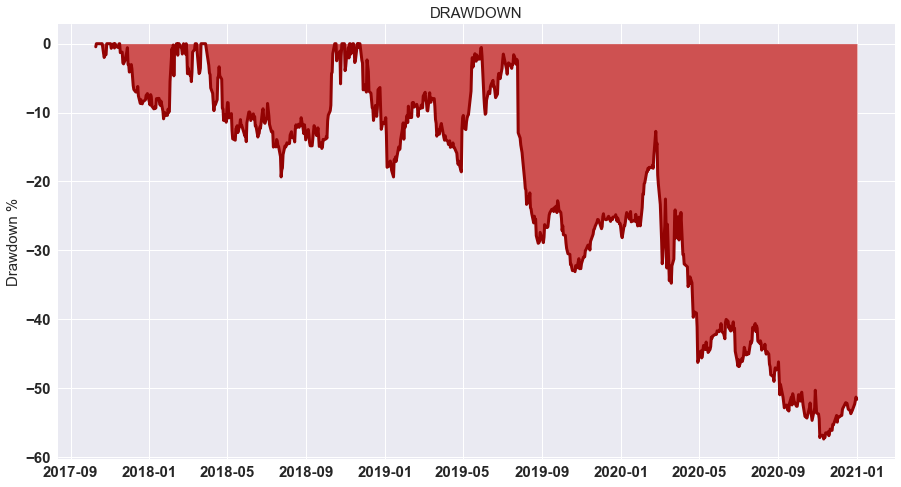

In [9]:
# Import the class
from sklearn.ensemble import RandomForestClassifier

# Initialize the class
lr = RandomForestClassifier()

# Fit the model
lr.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.001 	 Alpha: 315.67 %	     Sharpe: 14.104 	 Sortino: nan
  -----------------------------------------------------------------------------
    VaR: -263.93 %	 cVaR: -256.63 % 	     VaR/cVaR: 0.972 	 drawdown: -0.0 %
  -----------------------------------------------------------------------------


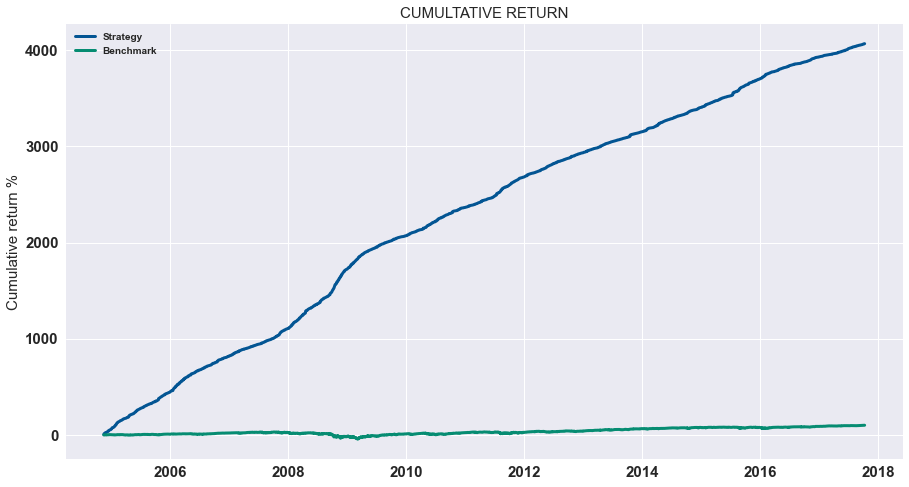

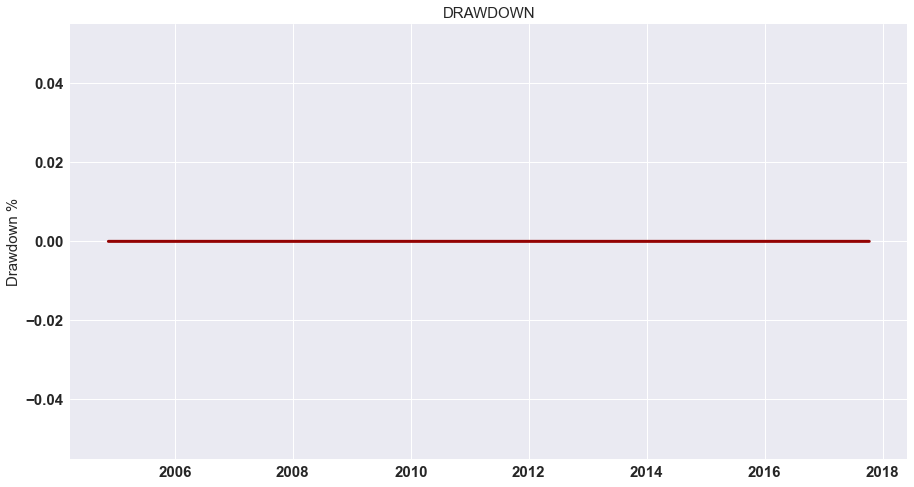

In [10]:
# Highlight the overfitting
backtest_dynamic_portfolio(df["strategy"].iloc[:split])

### 12.2.2. Random forest regressor

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.443 	 Alpha: 18.45 %	     Sharpe: 0.832 	 Sortino: 1.13
  -----------------------------------------------------------------------------
    VaR: 45.05 %	 cVaR: 54.77 % 	     VaR/cVaR: 1.216 	 drawdown: 35.03 %
  -----------------------------------------------------------------------------


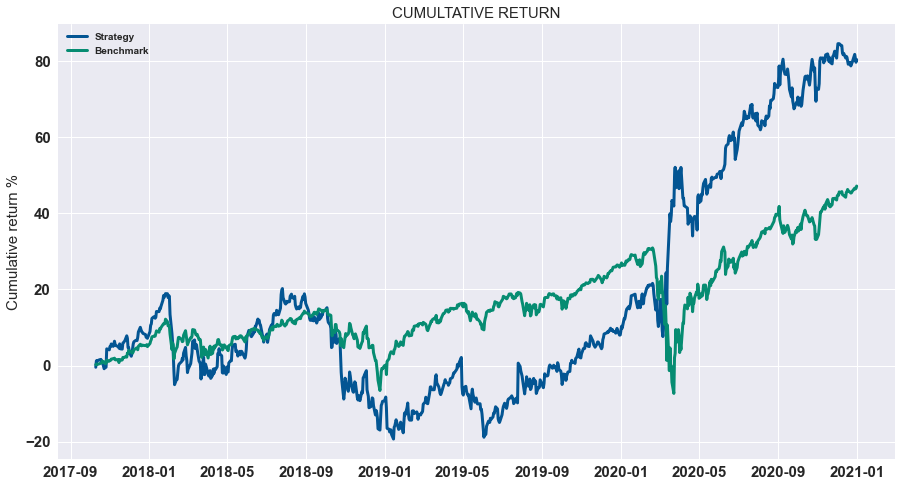

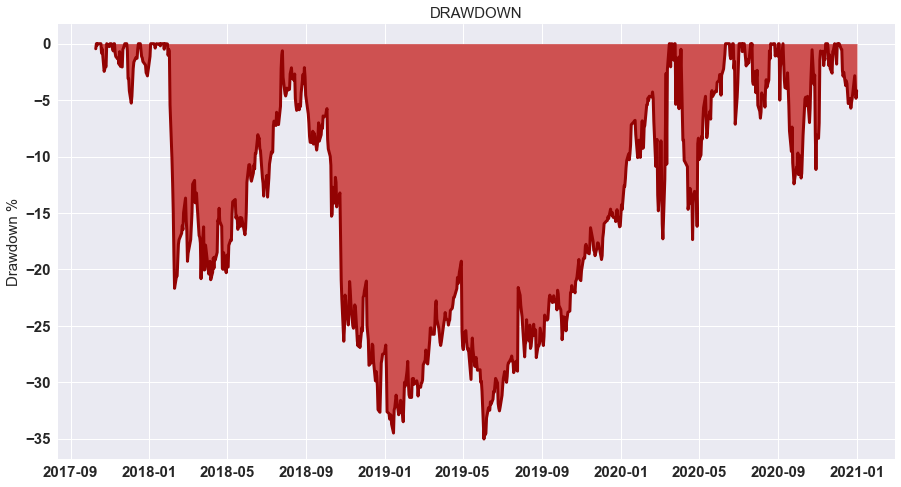

In [11]:
np.random.seed(15)
# Import the class
from sklearn.ensemble import RandomForestRegressor

# Initialize the class
lr = RandomForestRegressor(max_depth=6)

# Fit the model
lr.fit(X_train, y_train_reg)

# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.2.3. Optimize the hyperparameters

In [12]:
# Import the class
from sklearn.model_selection import GridSearchCV

# Create the model
dtr = RandomForestRegressor()

# Choose a list of parameters
param = {"max_depth": [3,6,15], "n_estimators": [50, 100, 150]}


# Import the function
from sklearn.metrics import make_scorer

# SHARPE
# Create sharpe criterion
def sharpe(y, y_pred):
    r = np.sign(y_pred) * y
    return np.mean(r) / np.std(r)

# Transform criterion into a metric
sharpe_metric  = make_scorer(sharpe, greater_is_better=True)


model = GridSearchCV(dtr, param_grid=param, scoring=sharpe_metric, cv=3)

model.fit(X_train.values, y_train_reg.values)

model.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=50)

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.553 	 Alpha: 18.25 %	     Sharpe: 0.879 	 Sortino: 1.194
  -----------------------------------------------------------------------------
    VaR: 44.05 %	 cVaR: 54.37 % 	     VaR/cVaR: 1.234 	 drawdown: 29.33 %
  -----------------------------------------------------------------------------


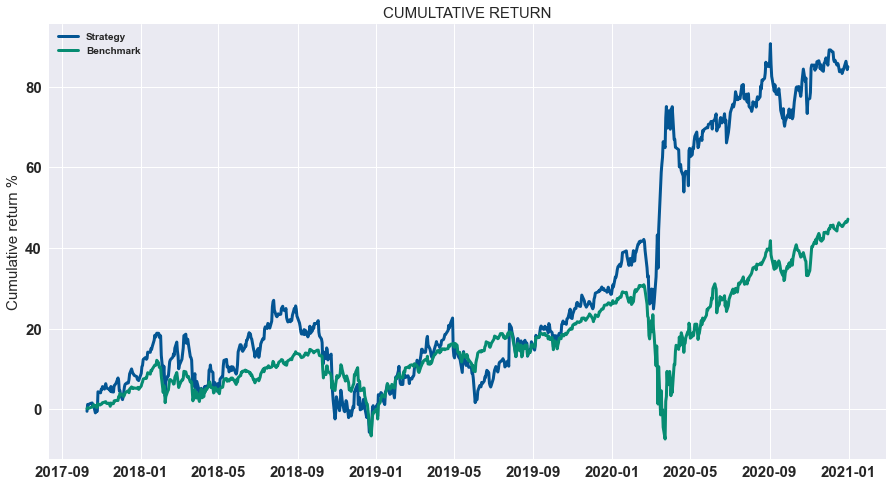

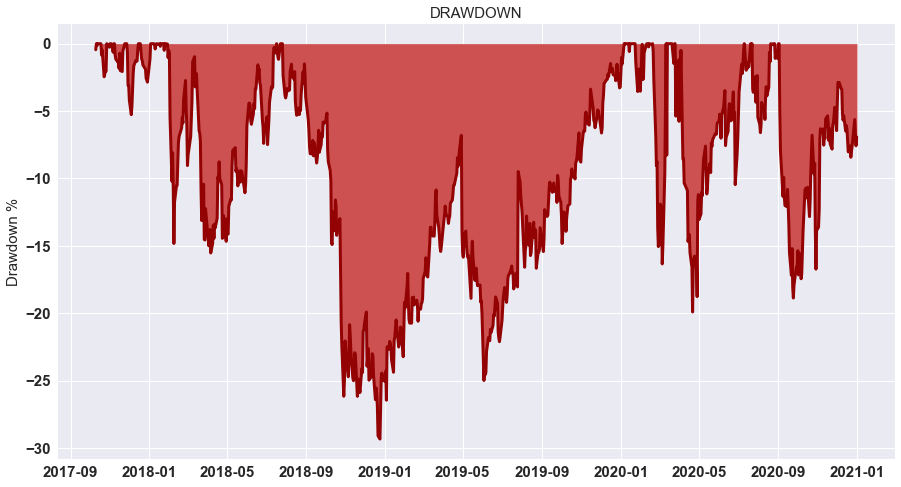

In [13]:
np.random.seed(15)
# Initialize the class
rfc = RandomForestRegressor(n_estimators=150, max_depth=3)

# Fit the model
rfc.fit(X_train, y_train_reg)
# Create predictions for the whole dataset
df["prediction"] = rfc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.157 	 Alpha: 23.01 %	     Sharpe: 0.691 	 Sortino: 1.035
  -----------------------------------------------------------------------------
    VaR: 49.1 %	 cVaR: 59.23 % 	     VaR/cVaR: 1.206 	 drawdown: 31.64 %
  -----------------------------------------------------------------------------


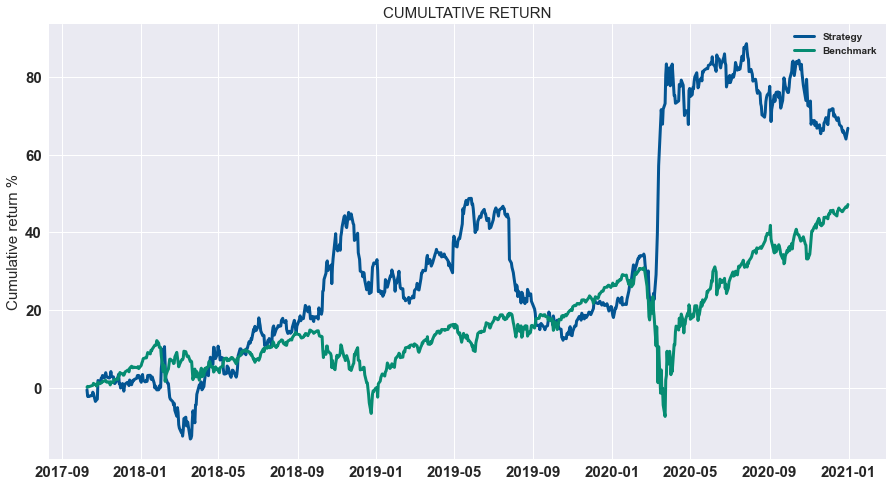

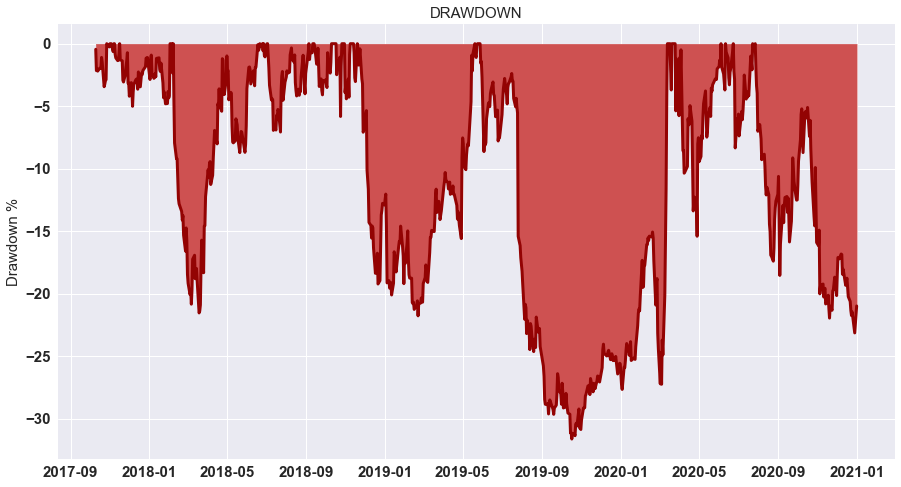

In [14]:
# Initialize the class
rfc = RandomForestRegressor()

# Fit the model
rfc.fit(X_train, y_train_reg)
# Create predictions for the whole dataset
df["prediction"] = rfc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.3.1. Voting method

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.056 	 Alpha: 7.16 %	     Sharpe: 0.754 	 Sortino: 0.968
  -----------------------------------------------------------------------------
    VaR: 47.4 %	 cVaR: 57.12 % 	     VaR/cVaR: 1.205 	 drawdown: 30.79 %
  -----------------------------------------------------------------------------


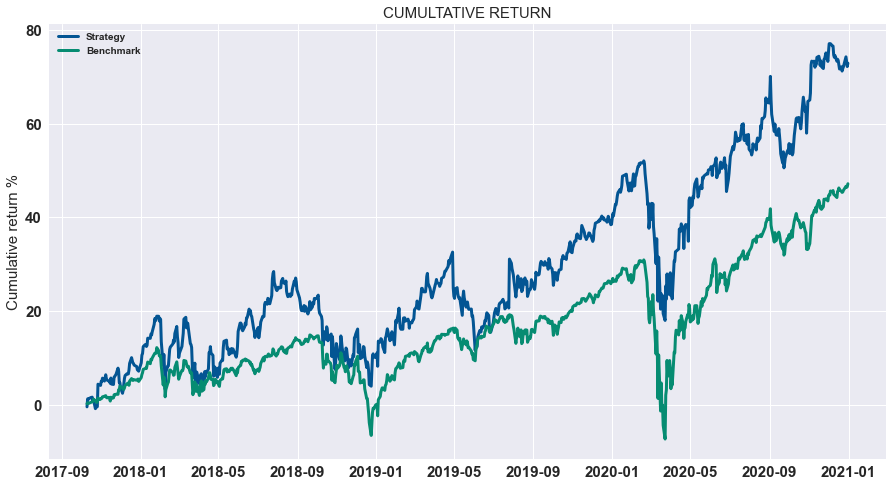

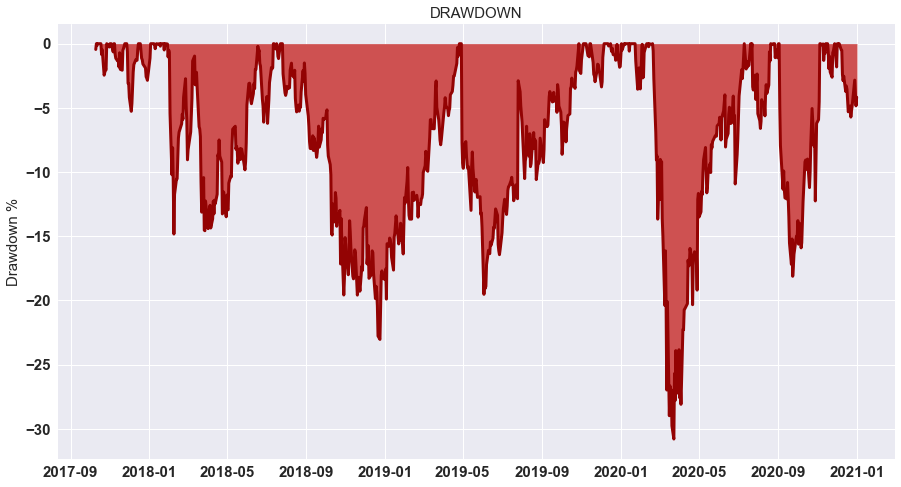

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, VotingRegressor

# Intitialize the estimators
clf1 = LinearRegression()
clf2 = RandomForestRegressor(n_estimators=150, max_depth=3)
clf3 = SVR(epsilon=1.5)

# Create the ensemble method
eclf1 = VotingRegressor(estimators=[
        ('lr', clf1), ('rf', clf2), ("svc", clf3)])

# Train the method
eclf1.fit(X_train, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = eclf1.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
np.random.seed(15)
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.3.2. Bagging method
Warnings: here, we take the scaled sets again because it is necessary for the SVMs.

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.056 	 Alpha: 7.16 %	     Sharpe: 0.754 	 Sortino: 0.968
  -----------------------------------------------------------------------------
    VaR: 47.31 %	 cVaR: 57.77 % 	     VaR/cVaR: 1.221 	 drawdown: 30.79 %
  -----------------------------------------------------------------------------


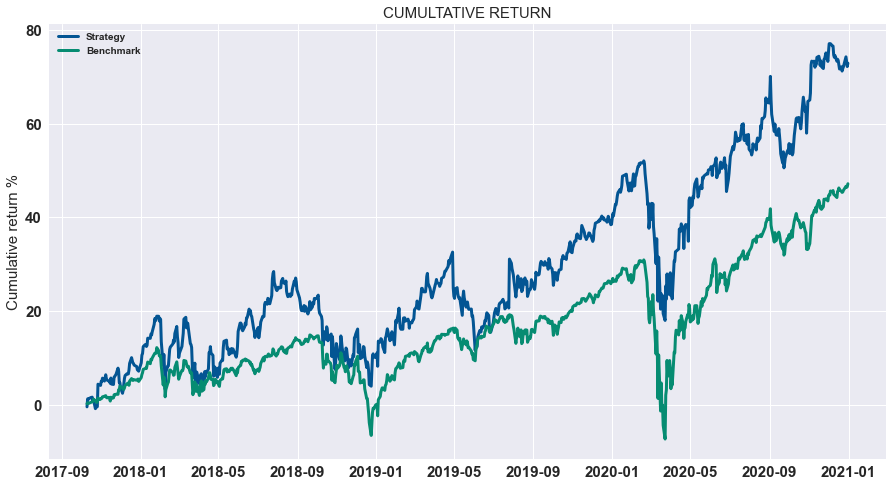

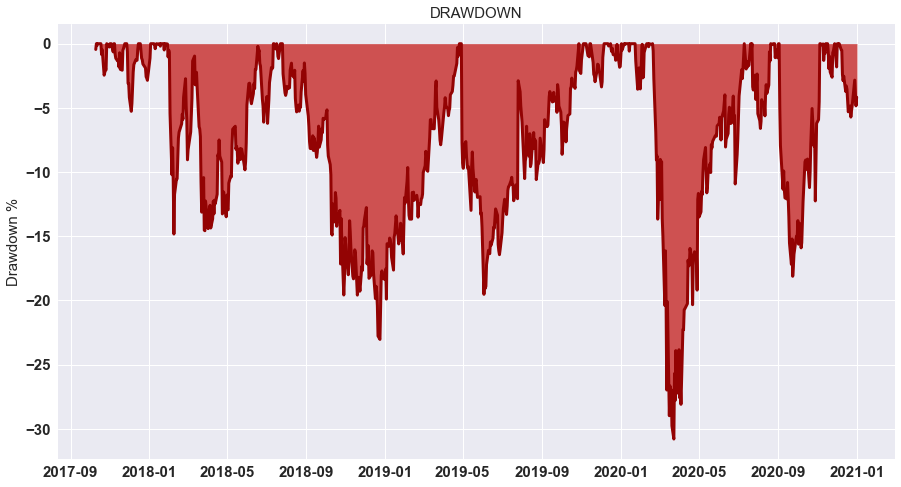

In [16]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

# Initialize the bagging
bag_reg = BaggingRegressor(SVR(epsilon=1.5), n_estimators=150)

# Train the method
bag_reg.fit(X_train_scaled, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = bag_reg.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 12.3.3. Stacking method

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.056 	 Alpha: 7.16 %	     Sharpe: 0.754 	 Sortino: 0.968
  -----------------------------------------------------------------------------
    VaR: 46.46 %	 cVaR: 56.64 % 	     VaR/cVaR: 1.219 	 drawdown: 30.79 %
  -----------------------------------------------------------------------------


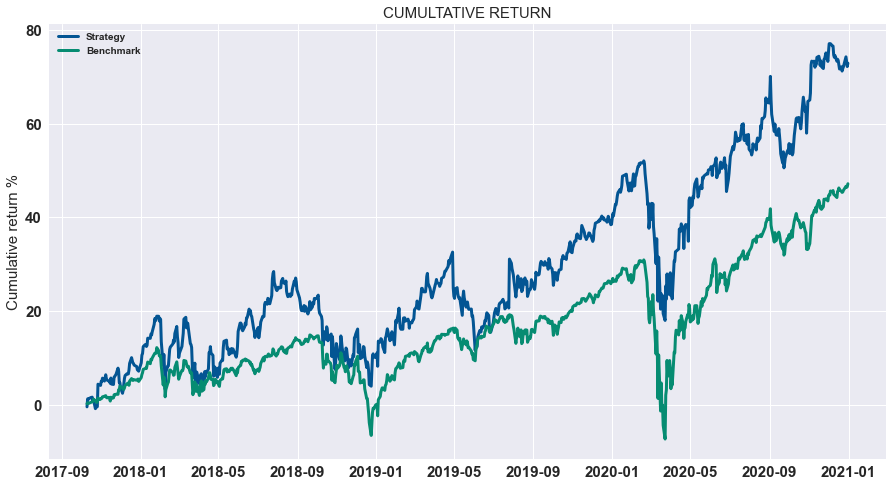

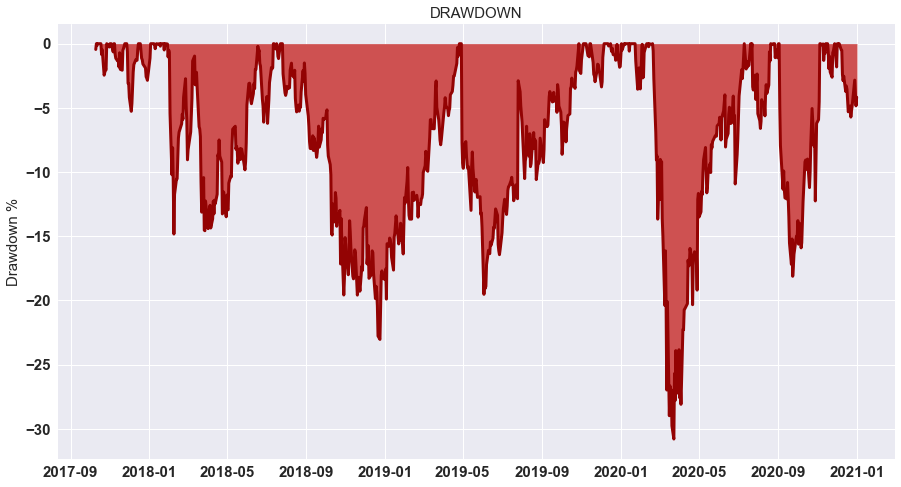

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Intitialize the estimators
clf1 = LinearRegression()
clf2 = RandomForestRegressor(n_estimators=150, max_depth=3)
clf3 = SVR(epsilon=1.5)

# Create the ensemble method
eclf1 = StackingRegressor(estimators=[
        ('lr', clf1), ('rf', clf2), ("svc", clf3)])

# Train the method
eclf1.fit(X_train, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = eclf1.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])